## Price Per Square Foot Prediction
In this notebook I predict the price per square foot of a house in Nashville, using an XGBoost. 
Metrics used are root mean squared error, median absolute error, and mean absolute error.
Since almost all numerical features of the dataset were heavily right-skewed, I have log-transformed every numerical feature except for the target variable (PPS).
I also ran a LightGBMRegressor which got almost the same results, but ran much faster.

### Observations

Quarter and Year are pretty essential variables but I wonder if there's a better way to incorporate time.


### Next step: incorporate data from historical sales.

### Consider adding average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [4]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()
#Dropping a few outliers
df=df[df.Fixtures <=23]
df=df[df['Land Area Acres'] <=8]
df=df[df.PPS <= 1100]

In [5]:
#Davidson County has used a massive number of "Building Types". I've coalesced many of them into broader categories.
TYPEDICT = {'HIGHRISE APT': 'HRISE', 'APARTMENT': 'CONDO', 'HRISE CONDO': 'HRISE',
            'RESD CONDO': 'CONDO', 'RW SING FAM': 'SINGLE FAM', 'SINGLE FAM': 'SINGLE FAM',
            'RZ SING FAM': 'SINGLE FAM', 'RH SING FAM': 'SINGLE FAM',
            'RY SING FAM': 'SINGLE FAM', 'MODULAR HOME': 'SINGLE FAM',
            'SING FAM': 'SINGLE FAM', 'RESD TRIPLEX': 'PLEX', 'RESD QUADPLX': 'PLEX',
            'R1 DUPLEX': 'PLEX', 'RES DUPLEX': 'PLEX', 'LODGE/FRAT\'L': 'THIRD',
            'CHURCH': 'THIRD', 'HEALTH CLUB': 'COMM', 'GROCERY/SMKT': 'COMM',
            'RETAIL/SHPG': 'COMM', 'DAYCARE': 'COMM', 'MARKET': 'COMM',
            'REST/BAR': 'COMM', 'OFFICE': 'COMM', 'WAREHOUSE': 'COMM',
            'EQUIP SHED': 'COMM', 'SERV GARAGE': 'COMM', 'TRUCK TERM': 'COMM',
            'ZERO LOT': 'VACANT', 'CAR WASH': 'COMM', 'MED OFC': 'COMM',
            'LAUNDRY': 'COMM', 'AUDITORIUM': 'THIRD', 'BANK': 'COMM', 'BOWLING': 'COMM',
            'BUSINESS CTR': 'COMM', 'CINEMA': 'COMM', 'CLUB/UNION': "THIRD",
            "COMM GRNHSE": "COMM", 'WHSE RETAIL': 'COMM', 'ENG/RESEARCH': 'COMM',
            'COUNTRY CLUB': 'THIRD', 'DEPT STORE': 'COMM', 'TENNIS': 'THIRD',
            'WALKUP APT': 'CONDO', 'DRUG STORE': 'COMM', 'DISC STORE': 'COMM',
            'ELDERLY HSG': 'CONDO', "FUNERAL HM": "THIRD", 'SALES SHOWRM': 'COMM',
            'LUMBER': 'COMM', 'MANF PLANT': 'COMM', 'MAINT HANGER': 'COMM',
            'MOTEL': 'COMM', 'MINI-LUBE': 'COMM', 'MINI-WAREHSE': 'COMM',
            'FAST FOOD': 'COMM', 'HOTEL': 'COMM', 'NURSING HOME': 'CONDO', "PARK'G GAR": 'COMM',
            'SERV STATION': 'COMM', 'INDOOR WP': 'COMM', 'HOSPITAL': 'THIRD', 'T-HANGER': 'COMM'
            }

df['Building Type Custom']=df['Building Type'].map(lambda x: TYPEDICT[x] if (x != '' and not pd.isnull(x)) else None)

In [6]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']=df['Log NbhdPPS'].replace(np.inf, np.nan)
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdRatio']=df['Log NbhdRatio'].replace(np.inf, np.nan)
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

In [7]:
df.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM,Average
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM,Average
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM,Average
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM,Average
244774,909 MULBERRY HILL PL,8,28000.0,8.158508,3432.0,SINGLE FAM,Average


In [8]:
df.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
279631,6264,752.879821
279737,6264,752.879821
279659,6264,752.879821
279602,6264,752.879821
279632,6264,752.879821


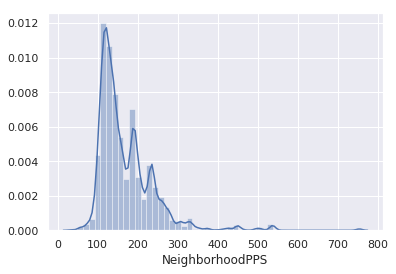

In [9]:
sns.distplot(df['NeighborhoodPPS'].dropna())

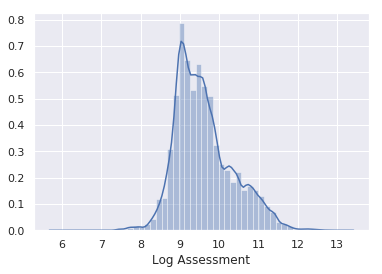

In [10]:
sns.distplot(df['Log Assessment'].dropna())

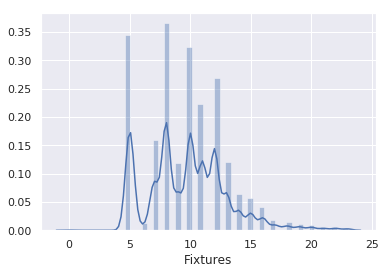

In [11]:
sns.distplot(df['Fixtures'].dropna())

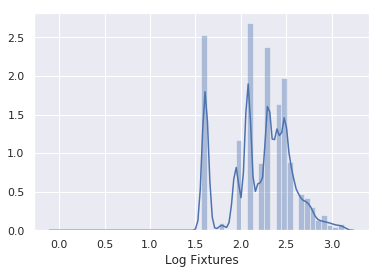

In [12]:
sns.distplot(df['Log Fixtures'].dropna())

In [13]:
df.nlargest(10, 'Land Area Acres')

,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,...,Month,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land,Log NbhdPPS,Log NbhdRatio
80374,RES,"$34,425","$31,175","$65,600",2019.0,2.0,3.0,Average,Average,C,...,10,4,2017,10.347372,2.302585,7.877397,5.358295,2.076938,4.718547,-2.918687
201384,RES,"$4,025","$24,575","$28,600",2019.0,1.0,NaN,Very Poor,NaN,D,...,8,3,2015,10.109485,1.609438,6.740519,4.937921,2.046402,5.022809,-1.975407
125549,RES,"$12,025","$36,925","$48,950",2019.0,1.0,NaN,Fair,NaN,D,...,9,3,2017,10.516644,1.609438,7.069874,5.237265,2.030776,4.974172,-2.198142
104137,RES,"$37,000","$43,050","$80,050",2019.0,1.0,NaN,Average,NaN,C,...,12,4,2016,10.670118,1.945910,7.344073,5.421616,2.029463,4.768629,-2.816275
104114,RES,"$33,125","$41,250","$74,375",2019.0,1.0,NaN,Fair,NaN,C,...,5,2,2017,10.627406,1.945910,7.832014,4.821944,1.981001,4.768629,-2.816275
144627,RES,"$105,425","$44,200","$149,625",2019.0,3.0,NaN,Average,NaN,B,...,3,1,2015,10.696480,2.397895,8.221210,5.085140,1.951608,4.947243,-2.580509
229502,RES,"$25,250","$63,000","$88,250",2019.0,2.0,NaN,Average,NaN,E,...,7,3,2017,11.050890,2.302585,7.731931,4.994423,1.948763,4.718547,-2.918687
190678,RES,"$253,125","$210,500","$463,625",2019.0,6.0,NaN,Average,NaN,X,...,11,4,2016,12.257241,3.135494,8.976641,5.426656,1.919859,5.402266,-2.047633
146606,RES,"$152,875","$140,825","$293,700",2019.0,4.0,NaN,Average,NaN,X,...,6,2,2015,11.855273,2.772589,8.797700,5.260757,1.912501,5.213084,-2.205598
128812,RES,"$302,600","$525,300","$827,900",2019.0,7.0,1.0,Fair,Fair,X,...,1,1,2015,13.171725,3.135494,8.966229,5.980684,1.902108,5.721254,-1.992677


In [14]:
np.std(df.PPS)

82.58664760002395

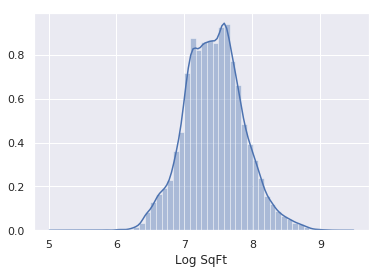

In [15]:
sns.distplot(df['Log SqFt'].dropna())

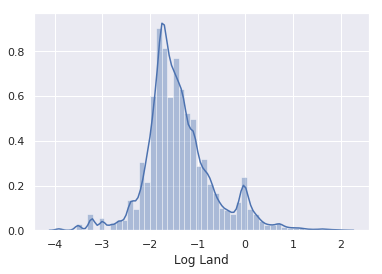

In [16]:
sns.distplot(df['Log Land'].dropna())

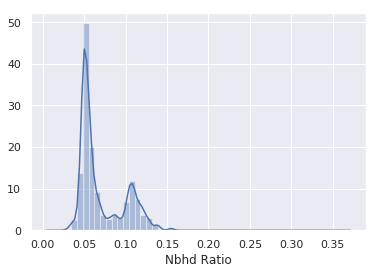

In [17]:
sns.distplot(df['Nbhd Ratio'].dropna())
df=df[df['Nbhd Ratio'] <= 0.3]

In [18]:
df.nlargest(10, 'Nbhd Ratio')['Neighborhood']

203808    4015
82509     6213
112819    2211
180687    6011
159814    6011
143683    6011
153896    9528
137965    9528
153549    9528
153568    9528
Name: Neighborhood, dtype: object

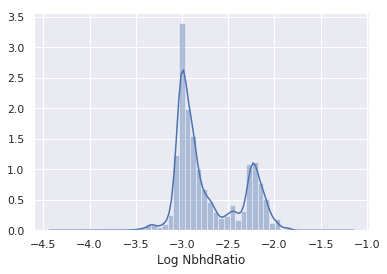

In [19]:
sns.distplot(df['Log NbhdRatio'].dropna())

In [20]:
meanpps.nlargest(20,'NeighborhoodPPS')

,NeighborhoodPPS
Neighborhood,
3211,778.711485
6264,752.879821
6442,536.781227
6375,523.752618
4267,506.597339
4098,495.971656
6444,463.819647
4264,449.984079
4262,448.504625


In [21]:
df.loc[252586]

Assessment Classification*                                                 RES
Assessment Improvement                                                $25,525 
Assessment Land                                                        $6,750 
Assessment Total                                                      $32,275 
Assessment Year                                                           2019
Baths                                                                        2
Beds2                                                                      NaN
Building Condition                                                     Average
Building Condition2                                                        NaN
Building Grade                                                               C
Building Grade2                                                            NaN
Building Type                                                       RESD CONDO
Building Type2                                      

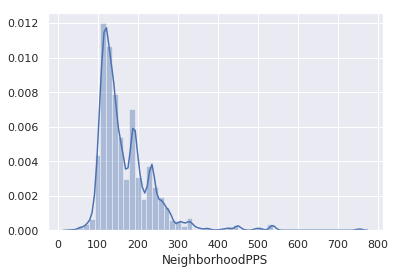

In [22]:
sns.distplot(df['NeighborhoodPPS'].dropna())
df=df[df.NeighborhoodPPS<=2000]

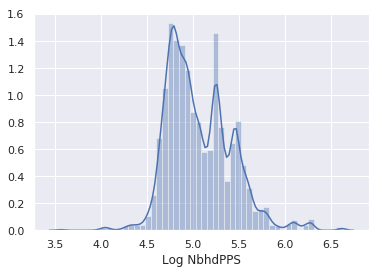

In [23]:
sns.distplot(df['Log NbhdPPS'].dropna())

## Now to the Machine Learning:

First I'll run a dummy regressor, which just guesses the mean. Then I'll attempt a few different models with increasing accuracy.

In [24]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error

In [25]:
df2 = df[['Log NbhdRatio','Building Condition','Log SqFt','Fixtures','Building Type Custom','Building Grade','Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built']]
df2=df2.dropna()

In [26]:
df2.columns = ['Log-NbhdRatio', 'Building-Condition', 'Log-SqFt', 'Fixtures',
       'Building-Type-Custom', 'Building-Grade', 'Exterior-Wall', 'Year',
       'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 'Year-Built']

In [27]:
df2.columns

Index(['Log-NbhdRatio', 'Building-Condition', 'Log-SqFt', 'Fixtures',
       'Building-Type-Custom', 'Building-Grade', 'Exterior-Wall', 'Year',
       'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 'Year-Built'],
      dtype='object')

In [28]:
from sklearn.model_selection import train_test_split
X= pd.get_dummies(df2[['Log-NbhdPPS','Building-Grade','Log-SqFt','Year', 'Log-Assessment','Fixtures','Exterior-Wall', 'Year-Built']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [29]:
print(df.shape)
print(df2.shape)

(53967, 80)
(53901, 13)


In [30]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_yyytest))**0.5)
print(MSE(y_pred, y_test)**0.5)

85.90201153981225


In [31]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

43.37705588976705


In [32]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


32.8634720084824


In [33]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_predxg, y_test)**0.5)
print(MAE(y_predxg,y_test))
print(mean_absolute_error(y_predxg,y_test))

[22:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


30.57656385712345
11.75542047001398
19.371662659425407


<Figure size 648x648 with 0 Axes>

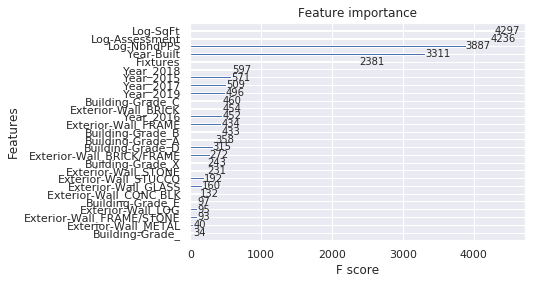

In [34]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

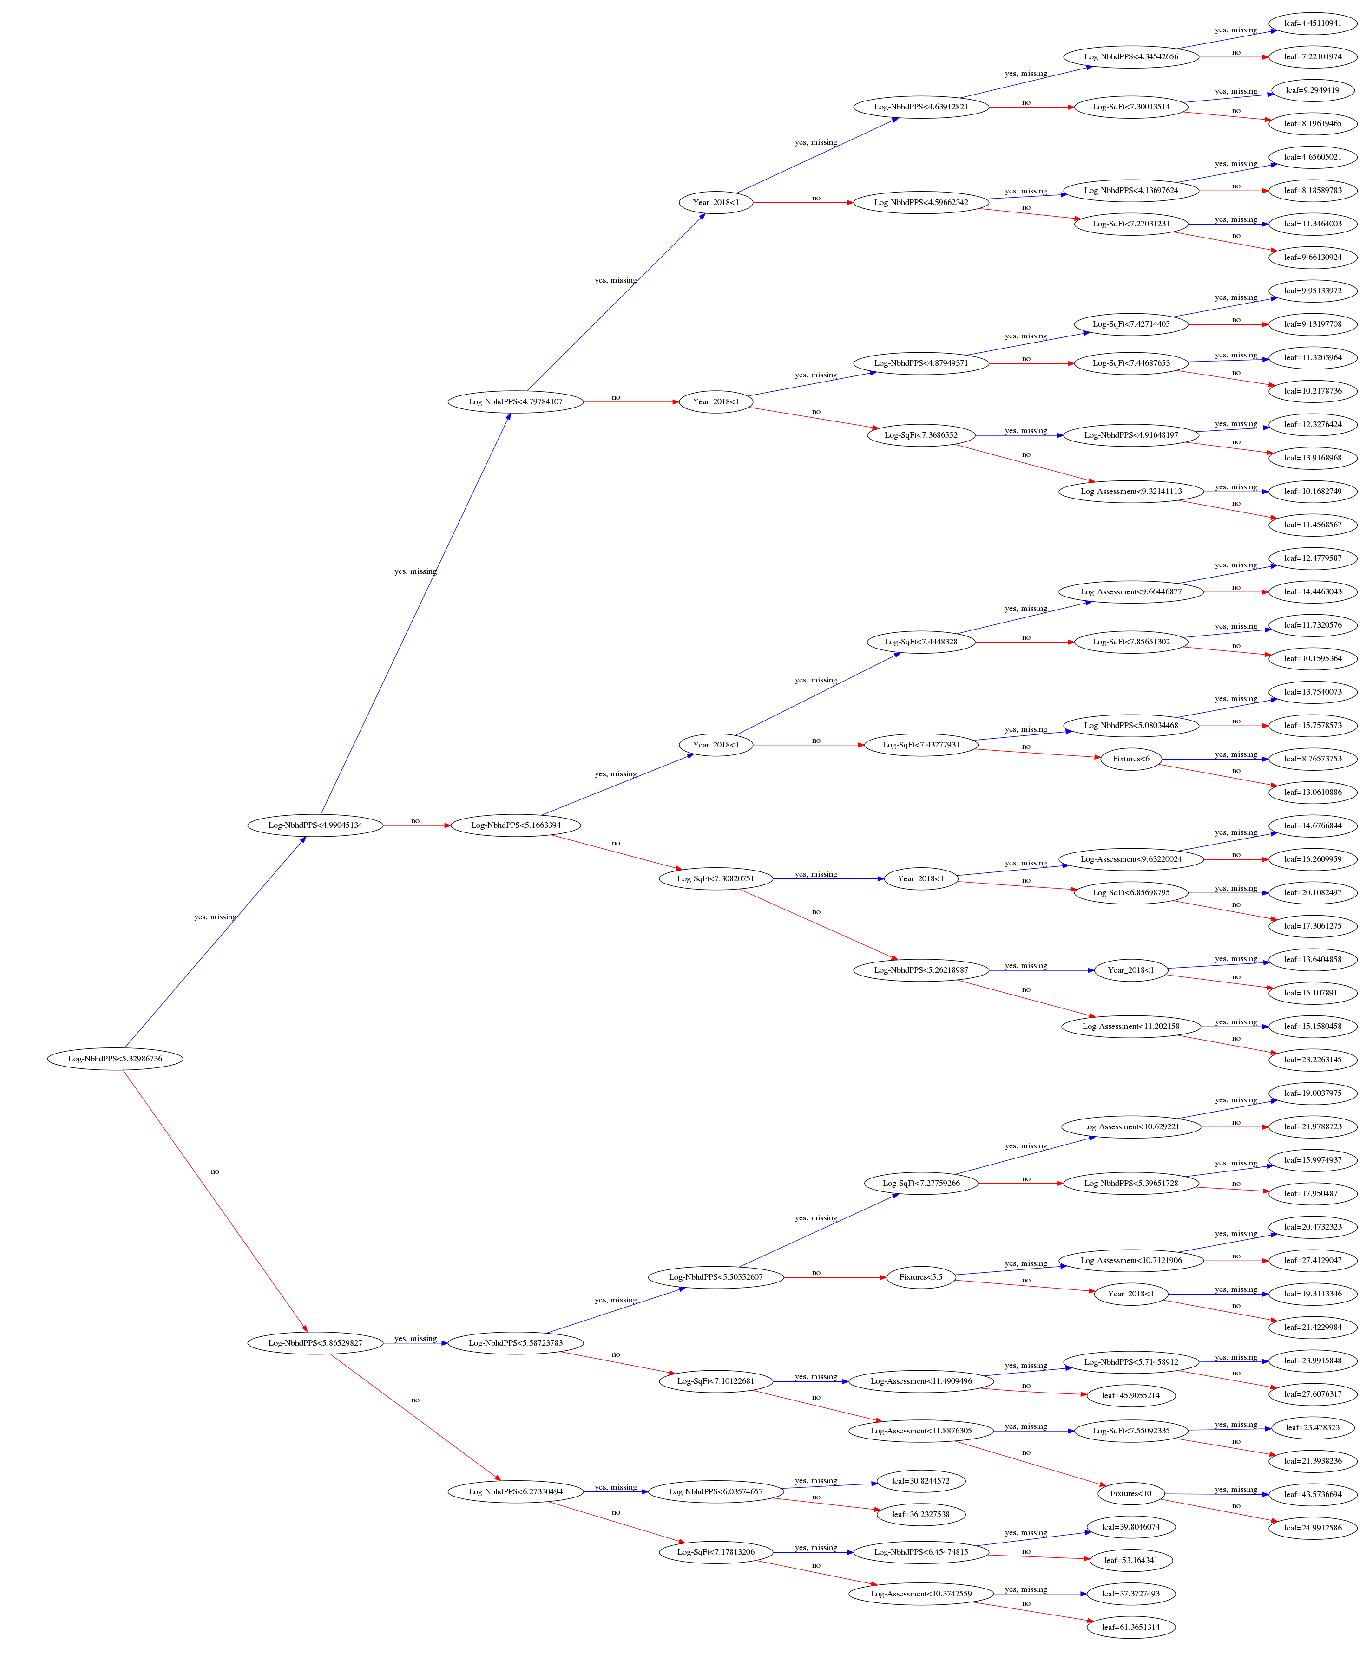

In [35]:
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show()

In [37]:
from sklearn.model_selection import GridSearchCV
params={'learning_rate':[.07,.08,.09]}
rfgrid = GridSearchCV(estimator = xgbr,param_grid=params, cv = 5, verbose=2, n_jobs = -1)
rfgrid.fit(X, y)

In [ ]:
print(MSE(y_test, rfgrid.best_estimator_.predict(X_test))**0.5) 
print(MAE(y_test, rfgrid.best_estimator_.predict(X_test)))
print(rfgrid.best_estimator_)

In [38]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(num_leaves=80,
                        learning_rate=0.25,
                        n_estimators=325)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=3)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

[1]	valid_0's l2: 4552.76	valid_0's l2: 4552.76
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's l2: 3167.43	valid_0's l2: 3167.43
[3]	valid_0's l2: 2365.03	valid_0's l2: 2365.03
[4]	valid_0's l2: 1891.94	valid_0's l2: 1891.94
[5]	valid_0's l2: 1616.39	valid_0's l2: 1616.39
[6]	valid_0's l2: 1439.97	valid_0's l2: 1439.97
[7]	valid_0's l2: 1333.51	valid_0's l2: 1333.51
[8]	valid_0's l2: 1257.63	valid_0's l2: 1257.63
[9]	valid_0's l2: 1206.91	valid_0's l2: 1206.91
[10]	valid_0's l2: 1168.02	valid_0's l2: 1168.02
[11]	valid_0's l2: 1135.47	valid_0's l2: 1135.47
[12]	valid_0's l2: 1113.36	valid_0's l2: 1113.36
[13]	valid_0's l2: 1095.63	valid_0's l2: 1095.63
[14]	valid_0's l2: 1079.37	valid_0's l2: 1079.37
[15]	valid_0's l2: 1068.17	valid_0's l2: 1068.17
[16]	valid_0's l2: 1058.06	valid_0's l2: 1058.06
[17]	valid_0's l2: 1044.45	valid_0's l2: 1044.45
[18]	valid_0's l2: 1038.44	valid_0's l2: 1038.44
[19]	valid_0's l2: 1031.42	valid_0's l2: 1031.42
[20]	valid_0's l2

In [39]:
np.sqrt(958.372)

30.957583885051495

In [40]:
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [500],
    'min_child_weight':[30,50],
    'max_depth': [5],
    'num_leaves': [350],
    }
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_pred= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_pred,y_test)**0.5)
print(MAE(y_pred,y_test))

Best parameters found by grid search are: {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 500, 'num_leaves': 350}
-948.1865232758394
30.413552011446455
11.52395420480542


In [41]:
gbm.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.18, max_depth=5,
       min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=350, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Examining where it went wrong

In [42]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

In [44]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the actual PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(15,'Residual')[['Log-NbhdPPS', 'Actual', 'Predicted', 'Residual']]

,Log-NbhdPPS,Actual,Predicted,Residual
110153,5.478194,723.981900,207.866745,516.115155
249856,6.227716,44.405998,498.806824,454.400826
144762,5.075999,588.505747,198.359970,390.145777
108662,5.570993,775.000000,448.504272,326.495728
272462,5.312365,525.986224,212.549637,313.436587
45773,5.048100,506.072874,206.924774,299.148100
129482,5.721254,158.653846,438.231934,279.578087
91666,5.248813,729.361702,460.045868,269.315834
133785,5.461321,508.905852,255.323685,253.582168
131843,5.648999,521.881288,284.274719,237.606568


In [45]:
copied= X_test.copy()
copied['Actual']= y_test
copied['Predicted']= y_pred
copied['Residual'] = np.absolute(copied['Actual'] - copied['Predicted'])

In [46]:
copied.nlargest(15, 'Residual')[['Actual','Predicted','Residual', 'Log-NbhdPPS']]

,Actual,Predicted,Residual,Log-NbhdPPS
110153,723.981900,210.143275,513.838625,5.478194
249856,44.405998,486.914248,442.508251,6.227716
144762,588.505747,200.629051,387.876696,5.075999
45773,506.072874,177.214961,328.857914,5.048100
272462,525.986224,204.773205,321.213019,5.312365
108662,775.000000,488.263189,286.736811,5.570993
91666,729.361702,459.074093,270.287609,5.248813
237106,924.991591,655.903383,269.088208,6.206519
133785,508.905852,253.699878,255.205974,5.461321
131843,521.881288,284.181673,237.699615,5.648999


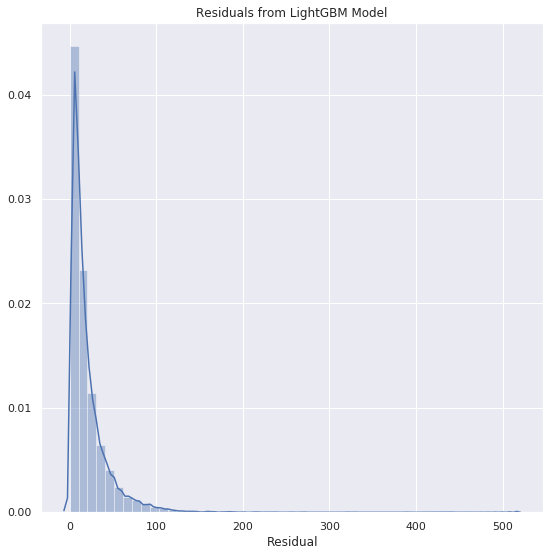

In [47]:
plt.figure(figsize=(9,9))
plt.title('Residuals from LightGBM Model')
sns.distplot(copied.Residual.dropna())

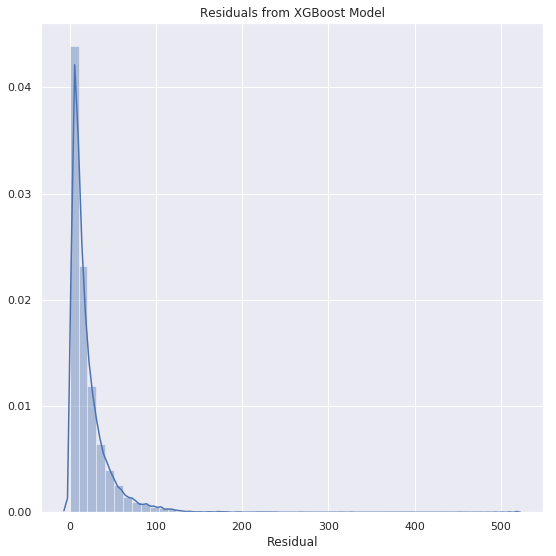

In [48]:
plt.figure(figsize=(9,9))
plt.title('Residuals from XGBoost Model')
sns.distplot(copiedxg.Residual.dropna())

In [49]:
df.nlargest(15, 'PPS')[['Sale Price', 'Location', 'PPS', 'Square Footage Improved', 'Log Land']]

,Sale Price,Location,PPS,Square Footage Improved,Log Land
261255,2125000.0,1212 LAUREL ST Unit 2307,1091.422702,1947.0,NaN
106716,621500.0,6012 HILL CIR,1078.993056,576.0,0.198851
279628,1125000.0,515 CHURCH ST Unit 3506,1068.376068,1053.0,NaN
261179,1950000.0,1212 LAUREL ST Unit 2001,1044.456347,1867.0,NaN
279725,1335000.0,515 CHURCH ST Unit 4304,1010.598032,1321.0,NaN
279704,1335000.0,515 CHURCH ST Unit 4104,1010.598032,1321.0,NaN
113967,3625000.0,1907 CONVENT PL,977.352386,3709.0,-0.867501
235871,1070000.0,320 BROADWAY Unit 301,971.843778,1101.0,NaN
279714,1270000.0,515 CHURCH ST Unit 4204,961.392884,1321.0,NaN
279730,1025000.0,515 CHURCH ST Unit 4308,954.376164,1074.0,NaN


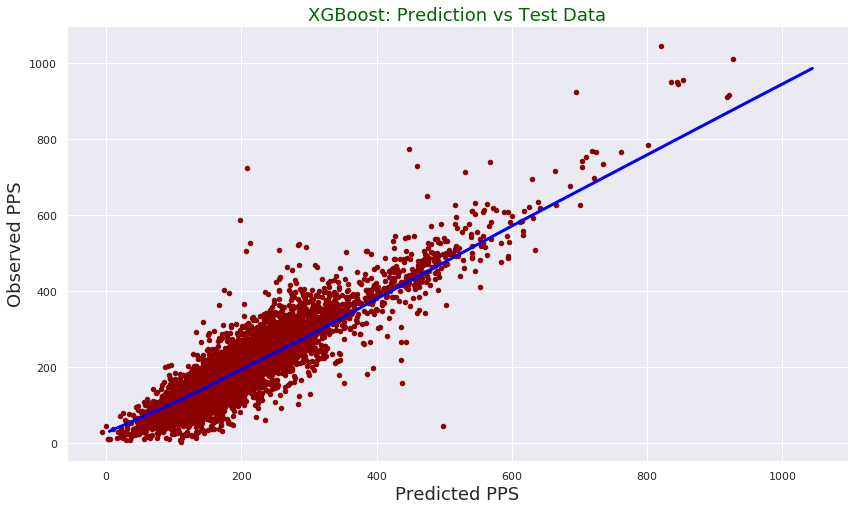

In [50]:
import statsmodels as sm
test = pd.DataFrame({"prediction": y_predxg, "observed": y_test})
lowess = sm.nonparametric.smoothers_lowess.lowess
z = lowess(y_predxg, y_test)
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("XGBoost: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted PPS", fontsize = 18) 
plt.ylabel("Observed PPS", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()